# 03 ImageClustering using PCA, Kmeans, DBSCAN

In this module you will be generating this graph, and describing that it means in terms os sanity checking your clusters, and what it means in terms of feature dimensions

![Assets/dbscan_graph.png](Assets/dbscan_graph.png)


## Learning Objectives

* Explore and interpret the image dataset

* Apply Intel® Extension for Scikit-learn* patches to Principal Components Analysis (PCA), Kmeans,and DBSCAN algorithms
* **Synthesize** your understanding- searching for ways to patch or unpatch any applicable cells to maximize the performance of each cell
* Apply a q.sh script to submit a job to another node that has a GPU on Intel DevCloud


<a id='Back_to_Sections'></a>

## Sections

- _Code:_ [Read Images](#Define-image-manipulation-and-Reading-functions)
- _Code:_ [Submit batch_clustering_Streamlined.py as a batch job](#Submit-batch_clustering_Streamlined.py-as-a-batch-job)
- _Code:_ [Plot Kmeans using GPU results](#Plot-Kmeans)
- _Code:_ [Plot DBSCAN using GPU results](#Plot-DBSCAN)

# Dependencies required:

- pip install pillow
- pip install seaborn

# Data Description

This data represent wildlife images taken by the author of thisnotebook. It is an UNBALANCED set of images of Collared Lizards, Pelicans, and Seascapes. The images are shot in various white balances to make clustering a challenge.  Additionally, the data are imbalalanced so that some lizrds were photographed in bright light, and some in shade. The goal is to perform clustering to aid eventual clsasification for use in a CNN semi-supervised learning exercise

The iamges are read in from a folder, and one by one that are reshaped to a single row with perhaps 60,000 columns (one image now per row). After they are assembled into a NumPy array there are scaled to zero mean, unit standard deviation to aid the Prinicpal Component step to have somewhat similar scale ranges.

The image array is tranaformed via PCA with 2 to 6 principal components shich changes the shape of the data we feed to kmeans or DBSCAn to n x c where c is the number of principal components we desire (likely in range from 2 to 6)

Then the data is plotted in a Seaborn pairplot to allow us to spot clusters visually, by which ever combo of principal components.

We use KMeans or DBSCAN to help automaticllay select which images belong to which cluster as reppresented by the color of the dots.

We also display an image grid of the clustered images to see if simialr images are clustered together to meet with our intuition.


# Practicum:

- Analyze each cell looking for places to patch or unpatch as needed to maximize the performace of each cell.
- Apply a patching strategy that applies the patch to every algorithm optimized by patching.
- Apply dpctl to run this on GPU


In [1]:
from __future__ import print_function
data_path = ['data']

# Notebook time start
from datetime import datetime

start_time = datetime.now()

current_time = start_time.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 12:32:51


# Define image manipulation and Reading functions

Leverage the code from **03_Applied_to_Image_Clustering_CPU** to read the images initially 

In [2]:
from lab.Read_Transform_Images import *

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


<a id='Actually-read-the-images'></a>
# Actually read the images

Using **Read_Transform_Images** from 03_Applied_to_Image_Clustering_CPU

- [Back to Sections](#Back_to_Sections)

In [3]:
resultsDict = {}
#resultsDict = Read_Transform_Images(resultsDict,imagesFilenameList = imagesFilenameList)
resultsDict = Read_Transform_Images(resultsDict,path = '../03_Applied_to_Image_Clustering_CPU/data/')
#resultsDict.keys()

Running Read_Transform_Images on CPU: 


# Display ImageGrid Random Sampling

This should give an idea of how closely or differently the various images appear. Notice that some of the collard lizard images have much differnet white balance and this will affect the clustering. For this dataset the images are clustered based on the similarity in RGB colorspace only.

You should notice several similar images of:
- Dark white balance lizards
- Light white balance lizards
- Skyscape with pelicans
- Seascapes with surf

Can an algorithm we design find clustering values in rough agreement to the above?

(24, 480, 640, 3)


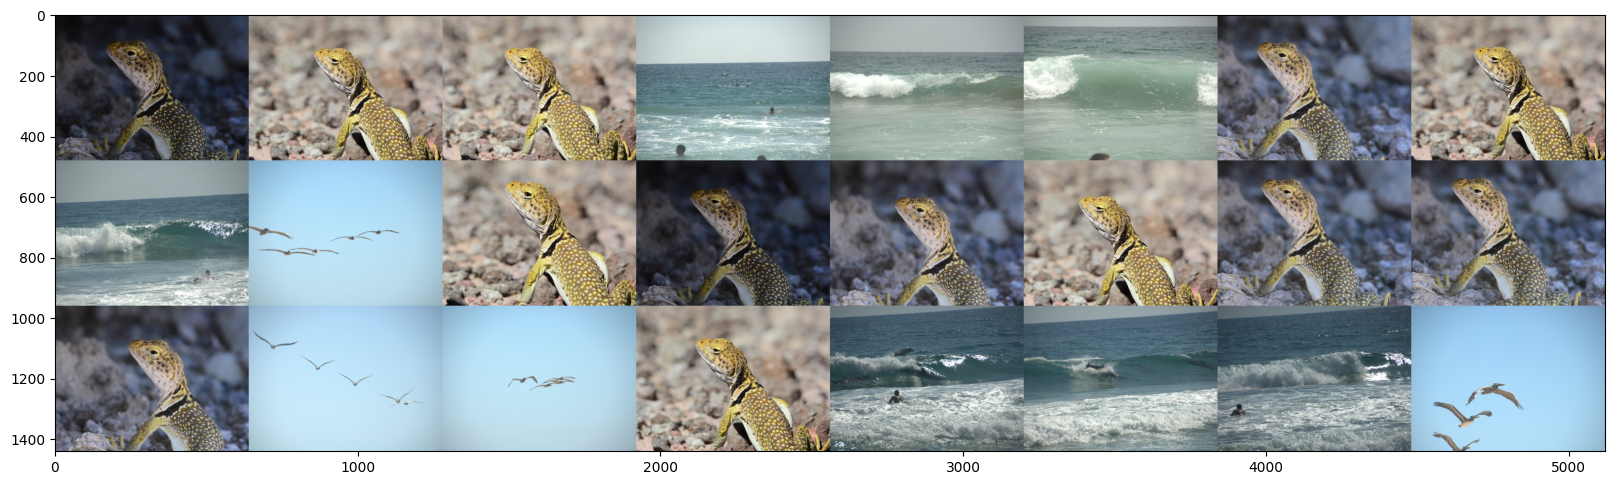

In [4]:
img_arr = []
ncols = 8
imageGrid=(ncols,3)
for pil in random.sample(resultsDict['list_PIL_Images'], imageGrid[0]*imageGrid[1])  :
    img_arr.append(np.array(pil))
#displayImageGrid(img_arr, imageGrid=imageGrid)
displayImageGrid2(img_arr, ncols=ncols)

## Create a Cell in the Style of a main() Python Script

This is a preperatory step for a later  when we qsub code to another compute node that has a GPU residing in it

After reading and transforming the data, will **compute PCA, Kmeans, DBSCAN all in one submission to the node containing the gpu**

In this case we run the code on a CPU first, for debugging and results checking.

**Careful:** The cell below uses a magic %%writefile which will write over the batch_clustering_Streamlined.py file. The execution of this cell simply writes to a python file - **this cell does not execute the code**.

In [5]:
%%writefile batch_clustering_Streamlined.py
# batch_clustering_Streamlined.py


#===============================================================================
# Copyright 2014-2021 Intel Corporation
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#===============================================================================

from sklearnex import patch_sklearn
patch_sklearn()
import dpctl

import matplotlib.pyplot as plt
import numpy as np
import glob
from PIL import Image
from PIL.Image import Image as PilImage
#from skimage.color import rgb2hsv
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import pandas as pd
import random
import operator
import seaborn as sns
import json


def ReshapeShortFat(original):
    """
    ReshapeShortFat(original)
    
    Reshapes the image numpy array from original shape 
    to the ShortFat single row shape and captures
    shape info in the output:
    channel_0, channel_1, channel_2
    
    functionally performs original.reshape(1, x*y*z) to create single row vector
    
    inputs:
        original - input the original image array
    
    return:
        ShortFatArray
        channel_0 - dimensions of the first channel - possibly the Red channel if using RGB
        channel_1 - dimensions of the first channel - possibly the Green channel if using RGB
        channel_2 - dimensions of the first channel - possibly the Blue channel if using RGB
    """       
    # preserve shape of incoming image
    channel_0, channel_1, channel_2 = original.shape
    #print('a shape ', a.shape)

    # convert to short, fat array
    ShortFatArray = original.reshape(1, channel_0*channel_1*channel_2)

    #print('a1 shape ', a1.shape)
    return ShortFatArray.squeeze(), channel_0, channel_1, channel_2

def Read_Transform_Images(resultsDict, 
                         imagesFilenameList = [], 
                         FSWRITE = False, path = '../03_Applied_to_Image_Clustering_CPU/data/'): 
    print('Running Read_Transform_Images on CPU: ')
    imageToClusterPath = path
    if len(imagesFilenameList) == 0:
        imagesFilenameList = [f for f in 
            sorted(glob.glob(imageToClusterPath 
            + '*.jpg'))]

    list_np_Images = []
    list_PIL_Images = []
    for im in imagesFilenameList:
        img =  Image.open(im)
        list_PIL_Images.append(img)
        a = np.asarray(img,dtype=np.float32)/255
        with np.errstate(divide='ignore', invalid='ignore'):
            #a1, x, y, z = ReshapeShortFat(rgb2hsv(a))
            a1, x, y, z = ReshapeShortFat(a)
        a2 = a1  # no image whitening for each file
        list_np_Images.append(a2)
    NP_images = np.array(list_np_Images)
    NP_images_STD = StandardScaler(with_std=True).fit_transform(NP_images)
    resultsDict['imagesFilenameList'] = imagesFilenameList
    resultsDict['list_PIL_Images'] = list_PIL_Images
    resultsDict['NP_images_STD'] = NP_images_STD
    if FSWRITE == True:
        write_results(resultsDict)
    return resultsDict

def displayImageGrid(img_arr, imageGrid=(4,5)):
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import ImageGrid
    import numpy as np
    import random

    fig = plt.figure(figsize=(20,20))
    grid = ImageGrid(fig, 111, 
                     nrows_ncols=imageGrid,  # creates 2x2 grid of axes
                     #axes_pad=0.1,  # pad between axes
                     )

    img_arr = np.array(img_arr)
    for ax, im in zip(grid, img_arr):
         ax.imshow(im)
    plt.show()   
    
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
    
def write_results_json(resultsDict):
    if 'list_PIL_Images' in resultsDict.keys():
        del resultsDict['list_PIL_Images']
    if 'NP_images_STD' in resultsDict.keys():
        del resultsDict['NP_images_STD']
    with open("results/resultsDict.json", "w") as outfile:
        json.dump(resultsDict, outfile, cls=NumpyEncoder)

def read_results_json():
    with open('results/resultsDict.json') as json_file:
        resultsDict = json.load(json_file)
    return resultsDict

def main():
    # Compute Follows Data
    # determine if GPU available:
    for d in dpctl.get_devices(): #loop thru all available devices
        gpu_available = False
        for d in dpctl.get_devices():  # Note if GPU is found
            if d.is_gpu:
                gpu_device = dpctl.select_gpu_device()  # get device context
                gpu_available = True
            else:
                cpu_device = dpctl.select_cpu_device()  # get device context
    if gpu_available:
        device = gpu_device
        print("GPU targeted: ", device)
    else:
        device = cpu_device
        print("CPU targeted: ", device)

    resultsDict = {}
    resultsDict = Read_Transform_Images(resultsDict)
    knee = 6   # number of clusters for KMeans
    EPS = 230  # EPS for dbscan
    n_components = 3  # nuber of components for PCA
    n_samples = 2     # number samples DBSCAN
    NP_images_STD = resultsDict['NP_images_STD'] # images as numpy array
    # Compute Follows Data: Determine if GPU is available
    if gpu_available:
        print('Running ComputePCA on GPU: ')   
        pca = PCA(n_components=n_components) # same as CPU
        
        ############### Difference bewteen CPU & GPU code ###################
        # convert data to dpctl.tensor prior to sklearnex call
        NP_images_STD_device = dpctl.tensor.from_numpy(NP_images_STD,  \
            usm_type = 'device', queue=dpctl.SyclQueue(device))
        #####################################################################    
        
        PCA_fit_transform = pca.fit_transform(NP_images_STD_device) # Use data/device on GPU
        k_means = KMeans(n_clusters = knee, init='random')
        db = DBSCAN(eps=EPS, min_samples = n_samples).fit(PCA_fit_transform) #use GPU data
        km = k_means.fit(PCA_fit_transform) #use GPU data
        # print types: any result you intend to pass around and use later
        # ensure it is converted to numpy prior to using it
        print("GPU: type(db.labels_)", type(db.labels_))
        print("GPU: type(km.labels_)", type(km.labels_))
        print("GPU: type(PCA_fit_transform)", type(PCA_fit_transform))
        
        ################  Cast returned dpctl.tensor._usmarray.usm_ndarray to numpy ###################
        print("GPU: type(dpctl.tensor.to_numpy(PCA_fit_transform))", type(dpctl.tensor.to_numpy(PCA_fit_transform)))
        ######################################################################################
        resultsDict['PCA_fit_transform'] = dpctl.tensor.to_numpy(PCA_fit_transform)
    else:
        print('Running ComputePCA on local CPU: ')
        device_context = 'cpu'
        pca = PCA(n_components=n_components)
        PCA_fit_transform = pca.fit_transform(NP_images_STD) 
        k_means = KMeans(n_clusters = knee, init='random')
        db = DBSCAN(eps=EPS, min_samples = n_samples).fit(PCA_fit_transform)
        km = k_means.fit(PCA_fit_transform) 
        resultsDict['PCA_fit_transform'] = PCA_fit_transform

    #resultsDict['device_context'] = device
    resultsDict['imageClusters_db'] = len(np.unique(db.labels_))
    resultsDict['counts_db'], resultsDict['bins_db']  = np.histogram(db.labels_, bins = EPS)
    resultsDict['counts'], resultsDict['bins'] =np.histogram(k_means.labels_, bins = knee)    
    resultsDict['imageClusters'] = len(np.unique(km.labels_))
    resultsDict['km_labels'] = km.labels_
    resultsDict['db_labels'] = db.labels_
    
    write_results_json(resultsDict)
    
    print("Kmeans bins   ", resultsDict['bins'])
    print("Kmeans counts ", resultsDict['counts'])
    
    print("All good inside main\n")
    
    return resultsDict

if __name__ == "__main__":
    resultsDict = main()
    #print("km_list: ", resultsDict['km_list'][0:2])
    print('All looks good!\nRun 03_Plot_GPU_Results.ipynb to graph the results!')

# Notices & Disclaimers 

# Intel technologies may require enabled hardware, software or service activation.
# No product or component can be absolutely secure.

# Your costs and results may vary.

# © Intel Corporation. Intel, the Intel logo, and other Intel marks are trademarks of Intel Corporation or its subsidiaries. 
# *Other names and brands may be claimed as the property of others.


Overwriting batch_clustering_Streamlined.py


We wrote the python file above. **We will read and execute it on the host now!**

We can load the file into a Jupyter cell for review or for execution on the login node by:
- %load batch_clustering_Streamlined.py

In [6]:
# %load batch_clustering_Streamlined.py
# batch_clustering_Streamlined.py


#===============================================================================
# Copyright 2014-2021 Intel Corporation
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#===============================================================================

from sklearnex import patch_sklearn
patch_sklearn()

import matplotlib.pyplot as plt
import numpy as np
import glob
from PIL import Image
from PIL.Image import Image as PilImage
#from skimage.color import rgb2hsv
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import pandas as pd
import random
import operator
import seaborn as sns
import json
import dpctl

def ReshapeShortFat(original):
    """
    ReshapeShortFat(original)
    
    Reshapes the image numpy array from original shape 
    to the ShortFat single row shape and captures
    shape info in the output:
    channel_0, channel_1, channel_2
    
    functionally performs original.reshape(1, x*y*z) to create single row vector
    
    inputs:
        original - input the original image array
    
    return:
        ShortFatArray
        channel_0 - dimensions of the first channel - possibly the Red channel if using RGB
        channel_1 - dimensions of the first channel - possibly the Green channel if using RGB
        channel_2 - dimensions of the first channel - possibly the Blue channel if using RGB
    """       
    # preserve shape of incoming image
    channel_0, channel_1, channel_2 = original.shape
    #print('a shape ', a.shape)

    # convert to short, fat array
    ShortFatArray = original.reshape(1, channel_0*channel_1*channel_2)

    #print('a1 shape ', a1.shape)
    return ShortFatArray.squeeze(), channel_0, channel_1, channel_2

def Read_Transform_Images(resultsDict, 
                         imagesFilenameList = [], 
                         FSWRITE = False, path = '../03_Applied_to_Image_Clustering_CPU/data/'): 
    print('Running Read_Transform_Images on CPU: ')
    imageToClusterPath = path
    if len(imagesFilenameList) == 0:
        imagesFilenameList = [f for f in 
            sorted(glob.glob(imageToClusterPath 
            + '*.jpg'))]

    list_np_Images = []
    list_PIL_Images = []
    for im in imagesFilenameList:
        img =  Image.open(im)
        list_PIL_Images.append(img)
        a = np.asarray(img,dtype=np.float32)/255
        with np.errstate(divide='ignore', invalid='ignore'):
            #a1, x, y, z = ReshapeShortFat(rgb2hsv(a))
            a1, x, y, z = ReshapeShortFat(a)
        a2 = a1  # no image whitening for each file
        list_np_Images.append(a2)
    NP_images = np.array(list_np_Images)
    NP_images_STD = StandardScaler(with_std=True).fit_transform(NP_images)
    resultsDict['imagesFilenameList'] = imagesFilenameList
    resultsDict['list_PIL_Images'] = list_PIL_Images
    resultsDict['NP_images_STD'] = NP_images_STD
    if FSWRITE == True:
        write_results(resultsDict)
    return resultsDict

def displayImageGrid(img_arr, imageGrid=(4,5)):
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import ImageGrid
    import numpy as np
    import random

    fig = plt.figure(figsize=(20,20))
    grid = ImageGrid(fig, 111, 
                     nrows_ncols=imageGrid,  # creates 2x2 grid of axes
                     #axes_pad=0.1,  # pad between axes
                     )

    img_arr = np.array(img_arr)
    for ax, im in zip(grid, img_arr):
         ax.imshow(im)
    plt.show()   
    
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
    
def write_results_json(resultsDict):
    if 'list_PIL_Images' in resultsDict.keys():
        del resultsDict['list_PIL_Images']
    if 'NP_images_STD' in resultsDict.keys():
        del resultsDict['NP_images_STD']
    with open("results/resultsDict.json", "w") as outfile:
        json.dump(resultsDict, outfile, cls=NumpyEncoder)

def read_results_json():
    with open('results/resultsDict.json') as json_file:
        resultsDict = json.load(json_file)
    return resultsDict

def main():
    # Compute Follows Data
    # determine if GPU available:
    for d in dpctl.get_devices(): #loop thru all available devices
        gpu_available = False
        for d in dpctl.get_devices():  # Note if GPU is found
            if d.is_gpu:
                gpu_device = dpctl.select_gpu_device()  # get device context
                gpu_available = True
            else:
                cpu_device = dpctl.select_cpu_device()  # get device context
    if gpu_available:
        device = gpu_device
        print("GPU targeted: ", device)
    else:
        device = cpu_device
        print("CPU targeted: ", device)

    resultsDict = {}
    resultsDict = Read_Transform_Images(resultsDict)
    knee = 6   # number of clusters for KMeans
    EPS = 230  # EPS for dbscan
    n_components = 3  # nuber of components for PCA
    n_samples = 2     # number samples DBSCAN
    NP_images_STD = resultsDict['NP_images_STD'] # images as numpy array
    # Compute Follows Data: Determine if GPU is available
    if gpu_available:
        print('Running ComputePCA on GPU: ')   
        pca = PCA(n_components=n_components) # same as CPU
        
        ############### Difference bewteen CPU & GPU code ###################
        # convert data to dpctl.tensor prior to sklearnex call
        NP_images_STD_device = dpctl.tensor.from_numpy(NP_images_STD,  \
            usm_type = 'device', queue=dpctl.SyclQueue(device))
        #####################################################################    
        
        PCA_fit_transform = pca.fit_transform(NP_images_STD_device) # Use data/device on GPU
        k_means = KMeans(n_clusters = knee, init='random')
        db = DBSCAN(eps=EPS, min_samples = n_samples).fit(PCA_fit_transform) #use GPU data
        km = k_means.fit(PCA_fit_transform) #use GPU data
        # print types: any result you intend to pass around and use later
        # ensure it is converted to numpy prior to using it
        print("GPU: type(db.labels_)", type(db.labels_))
        print("GPU: type(km.labels_)", type(km.labels_))
        print("GPU: type(PCA_fit_transform)", type(PCA_fit_transform))
        
        ################  Cast returned dpctl.tensor._usmarray.usm_ndarray to numpy ###################
        print("GPU: type(dpctl.tensor.to_numpy(PCA_fit_transform))", type(dpctl.tensor.to_numpy(PCA_fit_transform)))
        ######################################################################################
        resultsDict['PCA_fit_transform'] = dpctl.tensor.to_numpy(PCA_fit_transform)
    else:
        print('Running ComputePCA on local CPU: ')
        device_context = 'cpu'
        pca = PCA(n_components=n_components)
        PCA_fit_transform = pca.fit_transform(NP_images_STD) 
        k_means = KMeans(n_clusters = knee, init='random')
        db = DBSCAN(eps=EPS, min_samples = n_samples).fit(PCA_fit_transform)
        km = k_means.fit(PCA_fit_transform) 
        resultsDict['PCA_fit_transform'] = PCA_fit_transform

    #resultsDict['device_context'] = device
    resultsDict['imageClusters_db'] = len(np.unique(db.labels_))
    resultsDict['counts_db'], resultsDict['bins_db']  = np.histogram(db.labels_, bins = EPS)
    resultsDict['counts'], resultsDict['bins'] =np.histogram(k_means.labels_, bins = knee)    
    resultsDict['imageClusters'] = len(np.unique(km.labels_))
    resultsDict['km_labels'] = km.labels_
    resultsDict['db_labels'] = db.labels_
    
    write_results_json(resultsDict)
    
    print("Kmeans bins   ", resultsDict['bins'])
    print("Kmeans counts ", resultsDict['counts'])
    
    print("All good inside main\n")
    
    return resultsDict

if __name__ == "__main__":
    resultsDict = main()
    #print("km_list: ", resultsDict['km_list'][0:2])
    print('All looks good!\nRun 03_Plot_GPU_Results.ipynb to graph the results!')

# Notices & Disclaimers 

# Intel technologies may require enabled hardware, software or service activation.
# No product or component can be absolutely secure.

# Your costs and results may vary.

# © Intel Corporation. Intel, the Intel logo, and other Intel marks are trademarks of Intel Corporation or its subsidiaries. 
# *Other names and brands may be claimed as the property of others.


CPU targeted:  <dpctl.SyclDevice [backend_type.opencl, device_type.cpu,  Intel(R) Xeon(R) Gold 6128 CPU @ 3.40GHz] at 0x7feb2436ff30>
Running Read_Transform_Images on CPU: 


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Running ComputePCA on local CPU: 
Kmeans bins    [0.         0.83333333 1.66666667 2.5        3.33333333 4.16666667
 5.        ]
Kmeans counts  [3 6 3 4 6 4]
All good inside main

All looks good!
Run 03_Plot_GPU_Results.ipynb to graph the results!


<a id='Submit-batch_clustering_Streamlined.py-as-a-batch-job'></a>
# Submit batch_clustering_Streamlined.py

- [Back to Sections](#Back_to_Sections)

batch_clustering_Streamlined.py executed with a Python* command inside a shell script - run_clustering_streamlined.sh.

run_clustering_streamlined.sh is submitted as a batch job to a node which has GPUs

In [7]:
#!python batch_kmeans.py   # works on Windows
! chmod 755 q; chmod 755 run_clustering_streamlined.sh; if [ -x "$(command -v qsub)" ]; then ./q run_clustering_streamlined.sh; else ./run_clustering_streamlined.sh; fi

Job has been submitted to Intel(R) DevCloud and will execute soon.

 If you do not see result in 60 seconds, please restart the Jupyter kernel:
 Kernel -> 'Restart Kernel and Clear All Outputs...' and then try again

Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
2021750.v-qsvr-1           ...ub-singleuser u78349          00:01:08 R jupyterhub     
2021913.v-qsvr-1           ...treamlined.sh u78349                 0 Q batch          

Waiting for Output ███████████████████████████████████████████████████████████ Done⬇

########################################################################
#      Date:           Mon 31 Oct 2022 12:33:01 PM PDT
#    Job ID:           2021913.v-qsvr-1.aidevcloud
#      User:           u78349
# Resources:           neednodes=1:gen9:ppn=2,nodes=1:gen9:ppn=2,walltime=06:00:00
########################################################################

## u

<a id='Read-the-results-of-the-dictionary-after-GPU-computation'></a>
# We have successfully compted image clustering on Intel GPU using DPCTL!

### No further code changes required below this cell!

#### Read Results of the Dictionary After GPU Computation## Read Results of the Dictionary After GPU Computation

The rest of the cells below are simply to display the results from our GPU computation and explore hyperparameters such as EPS, number of clusters etc. We do these exploration on the **login node** for convenience.

- [Back to Sections](#Back_to_Sections)


In [8]:
# read results from json file in results folder
resultsDict = read_results_json()
# get list_PIL_Images from Read_Tansform_Images
resultsDict = Read_Transform_Images(resultsDict,path = '../03_Applied_to_Image_Clustering_CPU/data/')


Running Read_Transform_Images on CPU: 


<a id='Plot-Kmeans'></a>
# Plot Kmeans Clusters 

Plot a histogram of the using GPU results
-  [Back to Sections](#Back_to_Sections)

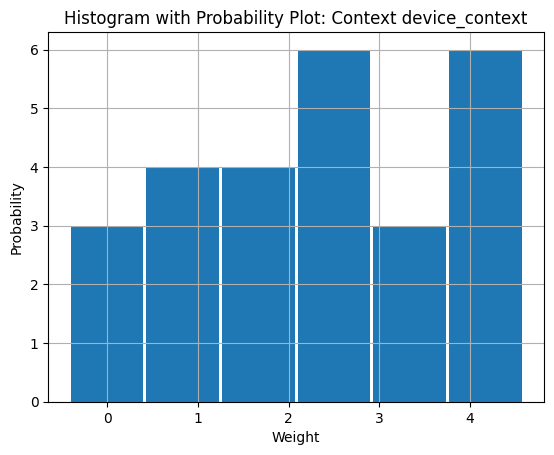

In [9]:
#resultsDict = Compute_kmeans_db_histogram_labels(resultsDict, knee = 6, gpu_available = gpu_available) #knee = 5
counts = np.asarray(pd.read_csv('data/counts_km.csv'))
bins = np.asarray(pd.read_csv('data/bins_km.csv'))
#counts = np.asarray(resultsDict['counts'])
#bins = np.asarray(resultsDict['bins'])
plt.xlabel("Weight")
plt.ylabel("Probability")
plt.title("Histogram with Probability Plot: Context {}".format('device_context'))
slice = min(counts.shape[0], bins.shape[0])
plt.bar(bins[:slice,0],counts[:slice,0])
plt.grid()
plt.show()

# Display Similar Images

Visually compare image which have been clustered by the allgorithm.

You may be surpirsed at the cluster grouping - what kmeans finds simialr or dissimilar based only on RGB colors

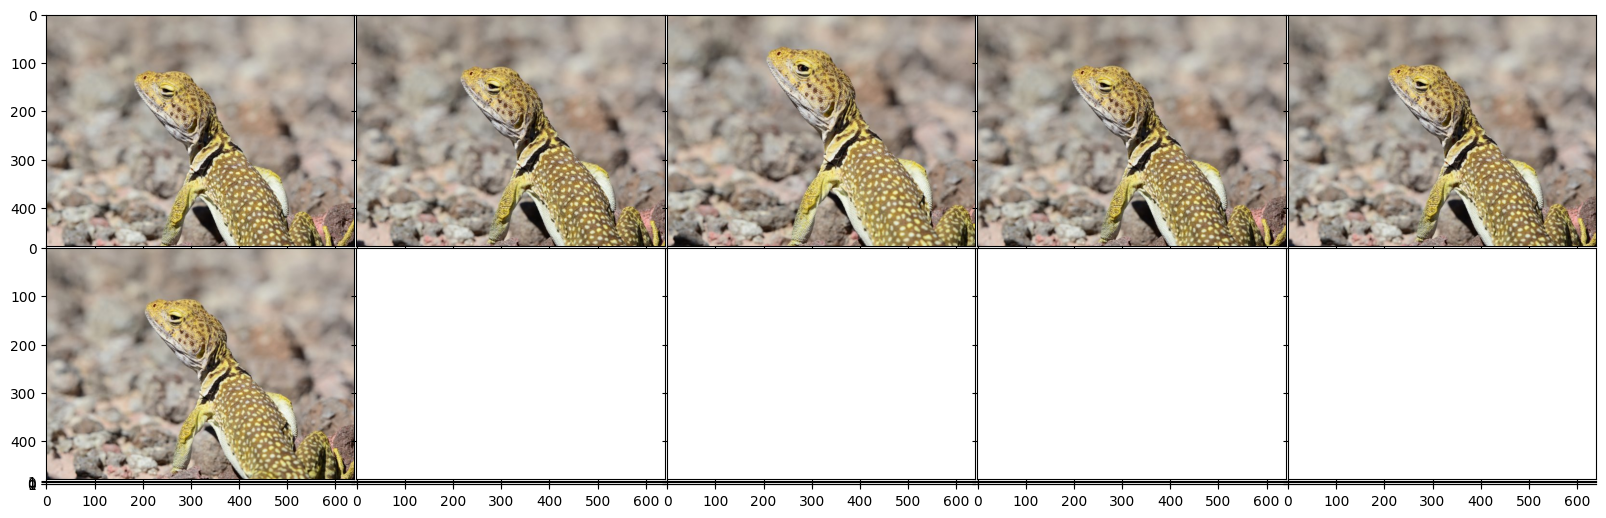

In [10]:
clusterRank = 0
km_labels = np.asarray(pd.read_csv('data/km_labels.csv'))
d = {i:cts for i, cts in enumerate(np.asarray(pd.read_csv('data/counts_km.csv')))}
sorted_d = sorted(d.items(), key=operator.itemgetter(1), reverse=True)

id = sorted_d[clusterRank][0] 
indexCluster = np.where(km_labels == id  )[0].tolist()
img_arr = []
for idx in indexCluster:
    img_arr.append(np.array((resultsDict['list_PIL_Images'][idx])))
img_arr = np.asarray(img_arr)
displayImageGrid(img_arr)

# Plot Seaborn Kmeans Clusters

Indicates numbers of images that are close in color space

<Figure size 800x800 with 0 Axes>

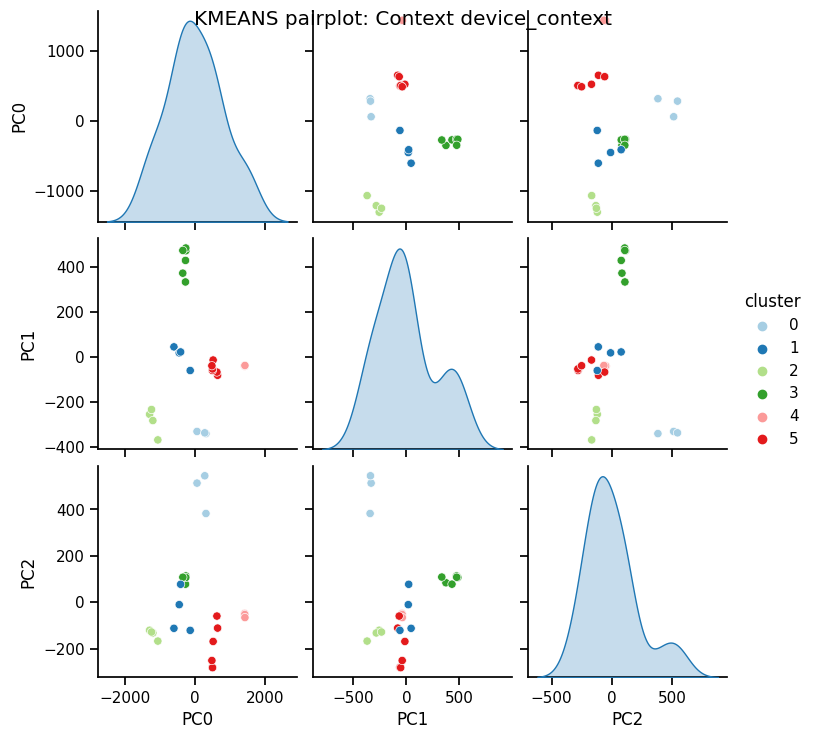

In [11]:
%matplotlib inline

n_components = 3

PCA_table = pd.read_csv('data/PCA_fit_transform.csv')
columns = ['PC{:0d}'.format(c) for c in range(n_components)]
data = pd.DataFrame(np.asarray(PCA_table)[:,:n_components], columns = columns)
#k_means = resultsDict['model']
data['cluster'] = km_labels
data.head()

columns.append('cluster')
plt.figure(figsize=(8,8))

sns.set_context('notebook');
g = sns.pairplot(data[columns], hue="cluster", palette="Paired", diag_kws=dict(hue=None));
g.fig.suptitle("KMEANS pairplot: Context {}".format('device_context'));

# Find DBSCAN EPS parameter

**We need to know roughly the size of EPS to try** 

Density-Based Spatial Clustering of Applications with Noise (DBSCAN) finds core samples of high density and expands clusters from them. Good for data which contains clusters of similar density.

EPS: "epsilon" value in sklearn is the maximum distance between two samples for one to be considered as in the neighborhood of the other.

At least a first value to start. We are using kNN to find distances commonly occuring in the dataset. Values of EPS below this threshold distance will be considered as lyig within a given cluster. This means we should look for long flat plateaus and read the y coordinate off the kNN plot to get a starting value for EPS.

Different datasets can have wildly different sweet spots for EPS. Some datasets require EPS values of .001 other datasets may work best with values of EPS of several thousand. We use this trick to get in the right or approximate neighborhood of the EPS.


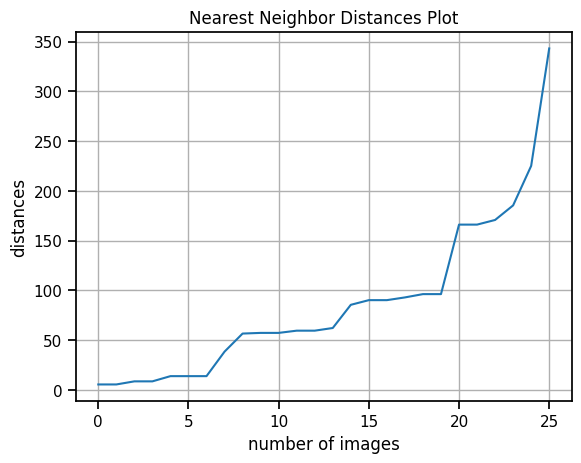

In [12]:
from sklearn.neighbors import NearestNeighbors

PCA_images = data

neighbors = NearestNeighbors(n_neighbors=2)
#X = StandardScaler().fit_transform(PCA_images)
neighbors_fit = neighbors.fit(PCA_images)
distances, indices = neighbors_fit.kneighbors(PCA_images)

distances = np.sort(distances, axis=0)
plt.xlabel('number of images')
plt.ylabel('distances')
plt.title('Nearest Neighbor Distances Plot')
plt.plot(distances[:,1])
plt.grid()

# Use DBSCAN to find clusters

Use initial estiamtes from KNN above (find elbow) to given initial trial for DBSCAN EPS values 

In the plot above, there is a plateau in the y values somewherre near 350 indicating that a cluster distance (aka EPS) might work well somewhere near this value. We used this value in the batch_clustering_Streamlined.py file when computing DBSCAN.

**EPS:** Two points are  neighbors if the distance between the two points is below a threshold.
**n:** The minimum number of neighbors a given point should have in order to be classified as a core point. 
The point itself is included in the minimum number of samples.

# Below: Find EPS That Minimizes Outliers

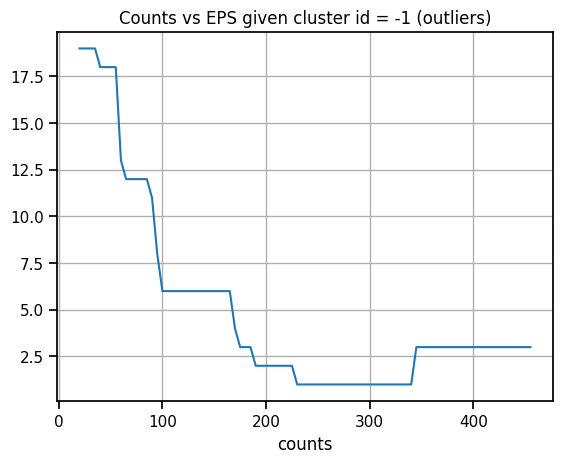

In [13]:
pca = PCA(n_components=n_components) #Compute on Login node for convenience
data = resultsDict['NP_images_STD']
PCA_fit_transform = pca.fit_transform(data) 
EPS = 230     # think od this as neighbor density
n_samples = 2 # we'll say that you have to have at least 2 points in a set to call it a cluster


e = []  # to hold eps sweep
c = []  # to hold counts sweep
for eps in  range(20,460, 5):
    db = DBSCAN(eps = eps, min_samples = n_samples).fit(PCA_fit_transform)
    counts = np.unique(db.labels_ , return_counts=True)
    e.append(eps)
    c.append(counts[1][0])
plt.plot(e,c)
plt.xlabel('eps')
plt.xlabel('counts')
plt.title('Counts vs EPS given cluster id = -1 (outliers)')
plt.grid()

In [14]:
#%%write_and_run    lab/compute_DBSCANClusterRank.py 

def compute_DBSCANClusterRank(n_samples = 3, n_components = 3, EPS = 230 ):
    pca = PCA(n_components=n_components)
    data = resultsDict['NP_images_STD']
    PCA_fit_transform = pca.fit_transform(data) 
    db = DBSCAN(eps=EPS, min_samples = n_samples).fit(PCA_fit_transform)

    counts = np.unique(db.labels_ , return_counts=True)
    d = {k:v for k, v in sorted(zip(counts[0], counts[1]), reverse=True, key=operator.itemgetter(1))}
    sorted_d = {k:v for k, v in sorted(zip(counts[0], counts[1]), reverse=True, key=operator.itemgetter(1))}
    return db, counts, sorted_d, PCA_fit_transform
data
n_components = 3
columns = ['PC{}'.format(i) for i in range(n_components)]
EPS = 230
db, counts, sorted_d, PCA_fit_transform = compute_DBSCANClusterRank(n_samples = 3, n_components = n_components, EPS = EPS)
PCAdf = pd.DataFrame(PCA_fit_transform, columns = columns)
PCAdf['cluster'] = db.labels_
print(sorted_d)

{1: 6, 2: 6, 5: 4, 0: 3, 3: 3, 4: 3, -1: 1}


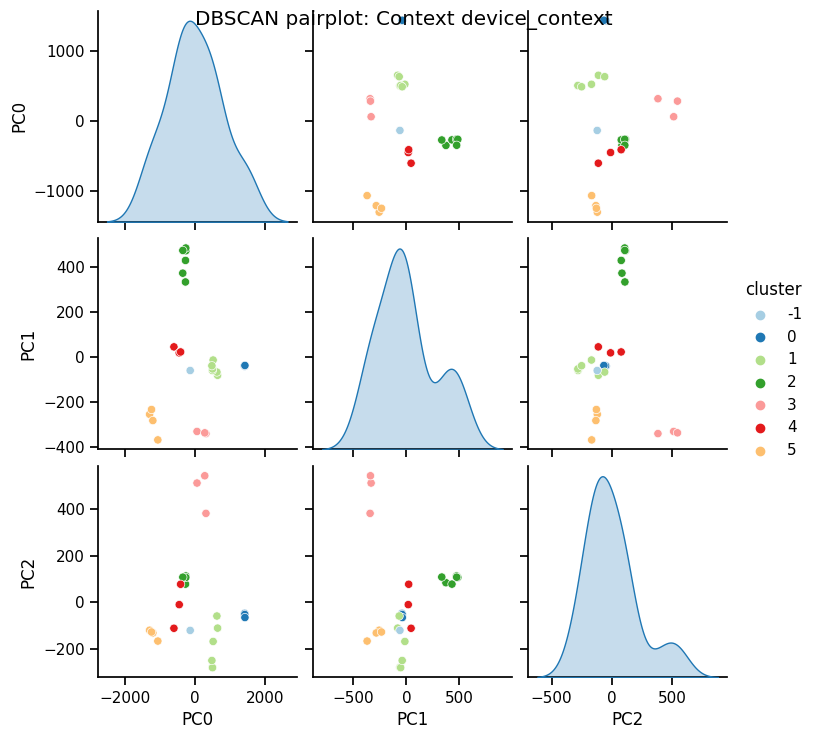

In [15]:
%matplotlib inline

sns.set_context('notebook');
g = sns.pairplot(PCAdf, hue="cluster", palette="Paired", diag_kws=dict(hue=None));
g.fig.suptitle("DBSCAN pairplot: Context {}".format('device_context'));

# Print Filenames of Outliers

In [16]:
print('Outlier/problematic images are: \n', 
      [resultsDict['imagesFilenameList'][f].split('/')[-1] for f in list(PCAdf[PCAdf['cluster'] == -1].index)]
     )

Outlier/problematic images are: 
 ['Ocean Waves (2).jpg']


<a id='Plot-DBSCAN'></a>
# DBSCAN Cluster Plots

Plot a histogram of the using GPU results
- [Back to Sections](#Back_to_Sections)

 

To indicate numbers of images in each cluster. color each point by its membership in a cluster

**Why read the counts and bins for DB from the csv from earlier?**

We will read the values from those saved earlier into a couple of csv files. THis is so later, when we modify for use with GPU on another node in the cluster, we can plot the results from that node.

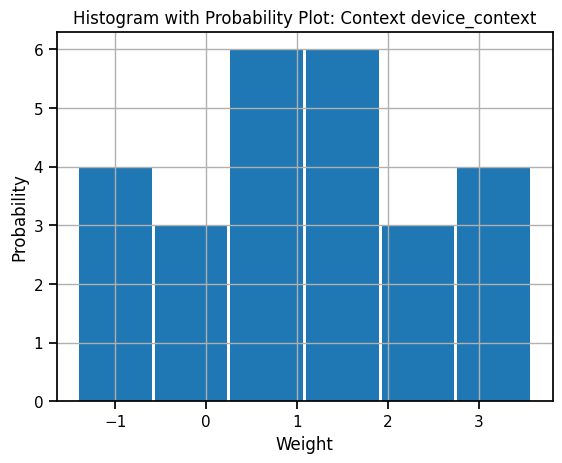

In [17]:
#resultsDict = Compute_kmeans_db_histogram_labels(resultsDict, knee = 6, gpu_available = gpu_available) #knee = 5
counts = np.asarray(pd.read_csv('data/counts_db.csv'))
bins = np.asarray(pd.read_csv('data/bins_db.csv'))
#counts = np.asarray(resultsDict['counts'])
#bins = np.asarray(resultsDict['bins'])
plt.xlabel("Weight")
plt.ylabel("Probability")
plt.title("Histogram with Probability Plot: Context {}".format('device_context'))
slice = min(counts.shape[0], bins.shape[0])
plt.bar(bins[:slice,0],counts[:slice,0])
plt.grid()
plt.show()

### We sort the dictionary containing the idx and counts of each cluster

We call the most frequently encoutered cluster, ClusterRank 0.  The next most frequently encoutered cluster,, is ClusterRank1, etc

Once we know the most common clusters, we can arrange the photos in a grid so we can see iamge clusters ot get a visual sense of similarity

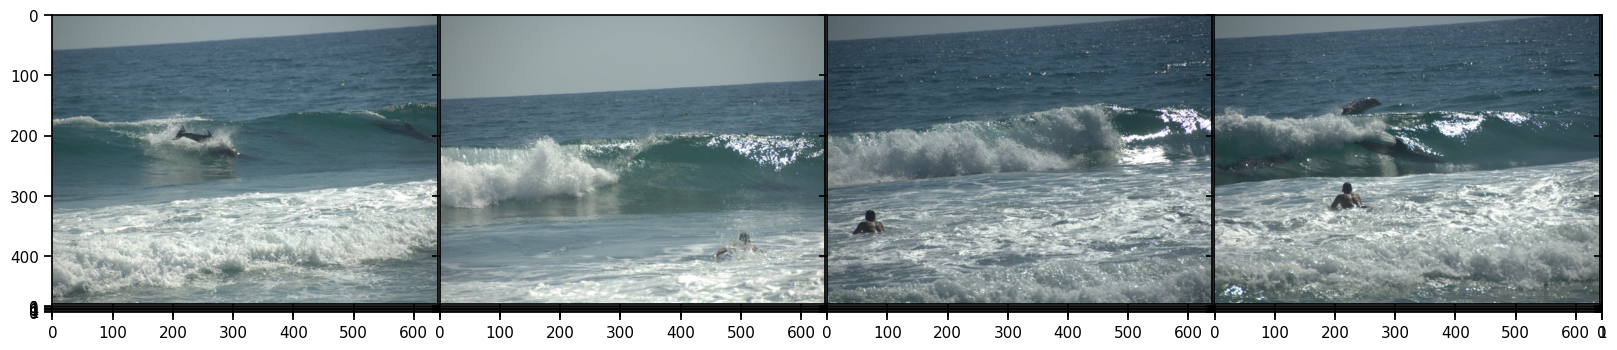

id:  -1


In [18]:
clusterRank = 2
db_labels = np.asarray(pd.read_csv('data/db_labels.csv'))
d = {i:cts for i, cts in enumerate(np.asarray(pd.read_csv('data/counts_db.csv')))}
sorted_d = sorted(d.items(), key=operator.itemgetter(1), reverse=True)

id = sorted_d[clusterRank][0] - 1
indexCluster = np.where(db_labels == id  )[0].tolist()
img_arr = []
for idx in indexCluster:
    img_arr.append(np.array((resultsDict['list_PIL_Images'][idx])))
img_arr = np.asarray(img_arr)
displayImageGrid(img_arr)
print('id: ',id)

# Final Thoughts and next steps...

You may have noticed how difficult it is to get decent clustering on even 30 or 40 images using only RGB or HSV as the feature set
.
If all the images are well separated in either RGB, or HSV color space, then these features are useful for clustering.

However, a suggested next step—or next training—would be to encode the data differently. Perhaps using image classification with VGG16, but removing the last layer as a preprocess prior to k-means or DBSCAN.


.

# Notices & Disclaimers 

Intel technologies may require enabled hardware, software or service activation.
No product or component can be absolutely secure.

Your costs and results may vary.

© Intel Corporation. Intel, the Intel logo, and other Intel marks are trademarks of Intel Corporation or its subsidiaries. 
*Other names and brands may be claimed as the property of others.



In [19]:
print("All Done")

All Done
